In [80]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [81]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")

In [82]:
X = sigmax()
Z = sigmaz()
Y = sigmay()
I = qeye(2)

s1 = tensor(Z, Z, I)
s2 = tensor(I, Z, Z)
S = [s1, s2]
X_L = tensor(X, X, X)
Z_L = (tensor(Z, I, I) + tensor(I, Z, I) + tensor(I, I, Z)) / 3
logical_zero = tensor(basis(2, 0), basis(2, 0), basis(2, 0))
logical_one = X_L * logical_zero
initial_state = logical_zero
n_qubits = 3

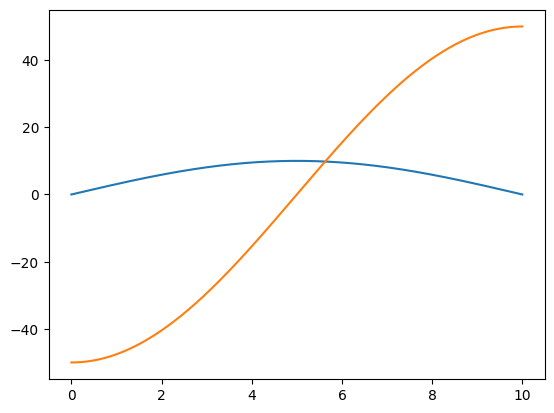

In [89]:
T_max = 10
times = np.linspace(0, T_max, 500)
sigma = 1
omega_max = 10
# omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max/2) / sigma) ** 2)
# delta_t = lambda t: 2*omega_max*(t / (T_max/2) - 1)
omega_t = lambda t: omega_max * np.sin(np.pi*t/T_max)
delta_t = lambda t: -5*omega_max * np.cos(np.pi*t/T_max)

plt.plot(times, omega_t(times))
plt.plot(times, delta_t(times))

In [90]:
def H(t):
    """
    Rapid Adiabatic Hamiltonian
    """
    return  X_L * omega_t(t) + Z_L * delta_t(t)

def H_error_gaussian(t, error_time, strength):
    """
    Error Hamiltonian localized at a specific time (e.g., bit-flip on the first qubit).
    """
    error_width = 0.5
    f_t = strength * np.exp(-((t - error_time) ** 2) / (2 * error_width ** 2))
    return f_t * tensor(X, I, I, I)

def H_error(t, error_time, strength, duration=2):
    if error_time <= t < error_time + duration:
        # ramp_strength = strength * (t - error_time) / duration
        bit_flip_1 = tensor(X, I, I)
        bit_flip_2 = tensor(I, X, I)
        bit_flip_3 = tensor(I, I, X)
        return strength * bit_flip_1
    else:
        # Identity when error is not active
        return tensor(I, I, I)

def H_supp(t, stabs=S):
    H_supp_stab = sum(stabs)
    return H_supp_stab
    
def H_total(t, error_time, error_strength, duration, Ep):
    """
    Total Hamiltonian including AQC evolution and error simulation.
    """
    H_n = H(t) + Ep * H_supp(t) + H_error(t, error_time, error_strength, duration)
    return H_n


In [85]:
# Ep = -200
# error_time = 6
# duration = T_max - error_time
# error_strength = 50

In [ ]:
# # Simulate evolution
# e_ops = [logical_zero*logical_zero.dag(), logical_one*logical_one.dag()]
#
# result = sesolve(lambda t: H_total(t, error_time, error_strength, duration, Ep),
#                  logical_zero, times, e_ops=e_ops,
#                  options={'nsteps': 1e5})
#
# plt.figure(figsize=(8, 6))
# plt.plot(times, result.expect[0], label=r"$|0_L\rangle$ Population", color='red')
# plt.plot(times, result.expect[1], label=r"$|1_L\rangle$ Population", color='blue')
# # Add vertical lines for the start and end of the error
# plt.axvline(error_time, color='black', linestyle='--', label="Error Start")
# plt.axvline(error_time + duration, color='black', linestyle='--', label="Error End")
#
# # Shade the area between the lines
# plt.fill_betweenx(
#     [0, 1],  # Adjust y-limits based on your data range
#     error_time,
#     error_time + duration,
#     color='gray',
#     alpha=0.3,
#     label="Error Region"
# )
#
# plt.xlabel("Time (t)")
# plt.ylabel("Population")
# plt.title("Logical State Populations with Bit-Flip Error")
# plt.legend()
# plt.grid()
# plt.show()

In [102]:
import plotly.graph_objects as go

Ep = 50
Hp = -Ep * sum(S)
# Calculate the initial Hamiltonian eigenstates
H_S_0 = omega_t(0) * X_L + delta_t(0) * Z_L + Hp
eigenvalues_0, eigenstates_0 = H_S_0.eigenstates()

# Initialize storage for the first two eigenstates and the rest
states = {index: [eigenvalues_0[index]] for index in range(len(eigenvalues_0))}

# Loop through time steps
for t_step in range(1, len(times)):
    H_S = omega_t(times[t_step]) * X_L + delta_t(times[t_step]) * Z_L + Hp
    eigenvalues, eigenstates = H_S.eigenstates()

    # Handle the first two eigenstates with overlap matching
    for state_index in range(2):  # Restrict to the first two eigenstates of H_S_0
        state_0 = eigenstates_0[state_index]
        max_overlap = 0
        best_match_index = 0

        for i, state_t in enumerate(eigenstates):
            proj = np.abs(state_0.overlap(state_t))**2
            if proj > max_overlap:
                max_overlap = proj
                best_match_index = i

        # Append the best matching eigenvalue for the first two eigenstates
        states[state_index].append(eigenvalues[best_match_index])

    # For the remaining eigenstates, just append their eigenvalues directly
    for state_index in range(2, len(eigenvalues)):
        states[state_index].append(eigenvalues[state_index])

# Create the plot
fig = go.Figure()

colors = ['red', 'blue']
for state_index, energies in states.items():
    if state_index < 2:  # Highlight the first two eigenstates
        fig.add_trace(go.Scatter(
            x=times,
            y=energies,
            mode='lines',
            line=dict(color=colors[state_index % len(colors)], width=2),
            name=f"Eigenstate {state_index + 1}"
        ))
    else:  # Plot the rest as dashed lines
        fig.add_trace(go.Scatter(
            x=times,
            y=energies,
            mode='lines',
            line=dict(color='black', width=1, dash='dash'),
            name=f"Eigenstate {state_index + 1}"
        ))

# Update layout
fig.update_layout(
    title="Energy Spectrum as a Function of Time",
    xaxis_title="Time [a.u.]",
    yaxis_title="Energy",
    font=dict(family="sans-serif", size=18),
    legend_title="Eigenstates",
    template="plotly"
)

# Show the plot
fig.show()

In [91]:
def bose_einstein_distribution(energy_diff, temperature):
    if temperature == 0:
        return 0
    return 1 / (np.exp(energy_diff / (temperature)) - 1)

def gab(omega1, omega2, lambda_2):
    if omega1 >= omega2:
        return 0
    return np.sqrt(lambda_2)

def c_ops_gen_new(t, args):
    H_inst_t = args['args_H'](t)  # Instantaneous Hamiltonian at time t
    eigenvalues, eigenstates = H_inst_t.eigenstates()
    c_s = []
    c_ops = []
    for a_i, a in enumerate(eigenstates):

        omega_a = eigenvalues[a_i]
        for b_i, b in enumerate(eigenstates[a_i+1:]):
            omega_b = eigenvalues[a_i + b_i + 1]
            
            c = b*a.dag()
            c_coef = 0
            for i in range(args['n_qubits']):
                sigmam_i = tensor([sigmam() if j == i else I for j in range(args['n_qubits'])])
                
                if np.abs(omega_a - omega_b) < 1e-6:
                    continue  # Skip nearly degenerate states
                
                # For decay transitions (omega_b > omega_a)
                if omega_b > omega_a:
                    Nba = bose_einstein_distribution(omega_b - omega_a, args['T'])
                    g_ba = gab(omega_a, omega_b, args['lambda_2'])

                    ma_ba = a.dag() * sigmam_i * b * b.dag() * sigmam_i.dag() * a
                    decay_op = np.sqrt(Nba * (g_ba ** 2) * ma_ba)
                    c_coef += decay_op

                # For excitation transitions (omega_a > omega_b)
                elif omega_a > omega_b:
                    Nab = bose_einstein_distribution(omega_a - omega_b, args['T'])
                    g_ab = gab(omega_b, omega_a, args['lambda_2'])
                    ma_ab = b.dag() * sigmam_i * a * a.dag() * sigmam_i.dag() * b
                    excitation_op = np.sqrt((Nab + 1) * (g_ab ** 2) * ma_ab)                    
                    c_coef += excitation_op
                    
                    
            if c_coef > 1e-5:
                c_ops.append(c.to('csr')*c_coef)
                c_s.append(c_coef)
            else:
                c_s.append(0)

    return c_ops, c_s

|ψ⟩ = 1.00|000⟩
0
1
2
3
4
5
10
25
50


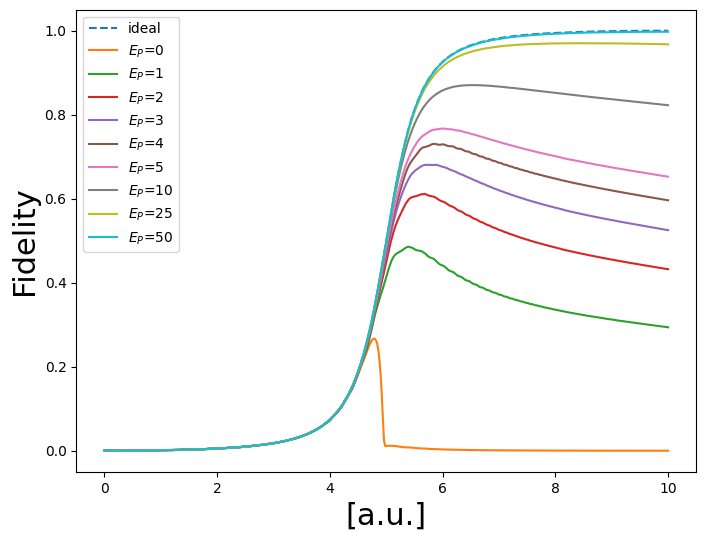

Done


In [93]:
print_quantum_state_as_superposition(initial_state)

 
times = np.linspace(0, T_max, 501) # has to be +1 for the final time stamp

nsteps = 1e5
gamma_sqrt = 0.1
T = 20 # temp

# Eps = [0, 50, 100, 200, 300]
Eps = [0, 1, 2, 3, 4, 5, 10, 25, 50]

rho0 = logical_zero * logical_zero.dag()
rho1 = logical_one * logical_one.dag()
e_ops = [rho0, rho1]

plt.figure(figsize=(8, 6))

# Plotting Ideal
def H_se(t):
    return omega_t(t) * X_L + delta_t(t) * Z_L

results_se = sesolve(H_se, logical_zero, times, e_ops=e_ops)
plt.plot(times, results_se.expect[1], linestyle="--", label=r"ideal")

# Loop over different values of Ep
for Ep in Eps:
    print(Ep)
    rho_init = initial_state * initial_state.dag()
    e_ops = [rho0, rho1]
    
    # Time-dependent Hamiltonian
    def H_t(t):
        H_RAP = X_L * omega_t(t) + Z_L * delta_t(t)
        
        Ht = H_RAP - Ep * sum(S)
        return Ht.to('csr')  # Assuming H_x and H_z are valid Qobjs

    args_C = {"args_H": H_t,
              "n_qubits": n_qubits,
              "lambda_2":gamma_sqrt,
              "T":T}

    prev_time = times[0]
    expects_0 = []
    expects_1 = []
    
    time_inter = times[1] - times[0]

    tot_time = times[1:]
    tot_time = np.append(tot_time, times[-1] + time_inter)
    
    for dt in tot_time:
        c_ops, c_s = c_ops_gen_new(dt, args=args_C)
        # c_ops = [i*1e-1 for i in [tensor(sigmam(),I,I), tensor(I,sigmam(),I), tensor(I,I,sigmam())]]

        t_steps = [prev_time, dt]
        results = mesolve(H_t, rho_init, t_steps, c_ops=c_ops, args=args_C, e_ops=e_ops,
                          options={'store_states': True})

        # Updating
        prev_time = dt
        rho_init = results.states[-1]

        # Saving
        expects_1.append(results.expect[1][0])
        expects_0.append(results.expect[0][0])
    
    # Plotting results
    expects_all = [expects_1[i] for i in range(len(expects_1))]

    plt.plot(times, expects_all, label=r"$E_{P}$=" + str(Ep))

    
    
plt.legend()
plt.xlabel('[a.u.]', size=22)
plt.ylabel('Fidelity', size=22)
plt.show()
plt.close()

print("Done")

# Plotting the evolution of transition coefficients (c_coef) over time
The plot illustrates the evolution of transition coefficients (c_coef) over time for various quantum state transitions. Notably, the transitions involving (0, i) and (1, i) remain consistently low throughout the protocol. This behavior is crucial as it ensures that the logical state remains confined to the ground space, preserving the fidelity of the quantum computation and minimizing leakage to higher energy states. This characteristic is essential for maintaining the robustness of the logical qubit during the adiabatic evolution.

In [77]:
def c_ops_gen_new_with_tracking(t, args):
    H_inst_t = args['args_H'](t)  # Instantaneous Hamiltonian at time t
    eigenvalues, eigenstates = H_inst_t.eigenstates()
    c_coef_tracking = {}
    for a_i, a in enumerate(eigenstates):
        omega_a = eigenvalues[a_i]
        for b_i, b in enumerate(eigenstates[a_i+1:]):
            omega_b = eigenvalues[a_i + b_i + 1]
            c_coef = 0
            for i in range(args['n_qubits']):
                sigmam_i = tensor([sigmam() if j == i else qeye(2) for j in range(args['n_qubits'])])
                if np.abs(omega_a - omega_b) < 1e-6:
                    continue  # Skip nearly degenerate states
                if omega_b > omega_a:  # Decay transitions
                    Nba = bose_einstein_distribution(omega_b - omega_a, args['T'])
                    g_ba = gab(omega_a, omega_b, args['lambda_2'])
                    ma_ba = a.dag() * sigmam_i * b * b.dag() * sigmam_i.dag() * a
                    c_coef += np.sqrt(Nba * (g_ba ** 2) * ma_ba)
                elif omega_a > omega_b:  # Excitation transitions
                    Nab = bose_einstein_distribution(omega_a - omega_b, args['T'])
                    g_ab = gab(omega_b, omega_a, args['lambda_2'])
                    ma_ab = b.dag() * sigmam_i * a * a.dag() * sigmam_i.dag() * b
                    c_coef += np.sqrt((Nab + 1) * (g_ab ** 2) * ma_ab)
            # Store c_coef for transition (a_i, b_i)
            transition_key = (a_i, a_i + b_i + 1)
            if transition_key not in c_coef_tracking:
                c_coef_tracking[transition_key] = []
            c_coef_tracking[transition_key].append(c_coef)
    return c_coef_tracking

# Define args
args = {
    "args_H": lambda t: omega_t(t) * X_L + delta_t(t) * Z_L - 0 * sum(S),
    "n_qubits": 3,
    "lambda_2": 0.1,
    "T": 100
}


In [94]:
import plotly.graph_objects as go
# Initialize c_coef_tracking
c_coef_tracking = {}
times = np.linspace(0, T_max, 101)

for t in times:
    c_coef_t = c_ops_gen_new_with_tracking(t, args)
    for key, values in c_coef_t.items():
        if key[0] != 0: # and key[0] != 1:
            continue  # Skip transitions that are not (0, i) or (1, i)
        if key not in c_coef_tracking:
            c_coef_tracking[key] = []
        # Convert complex values to real values (e.g., absolute values)
        c_coef_tracking[key].extend([np.abs(value) for value in values])

# Create interactive plot
fig = go.Figure()

for transition, coefs in c_coef_tracking.items():
    fig.add_trace(go.Scatter(
        x=times,
        y=coefs[:len(times)],
        mode='markers',
        name=f"Transition {transition}"  # Label for hover/click
    ))

fig.update_layout(
    title="Evolution of c_coef Per Transition Over Time",
    xaxis_title="Time",
    yaxis_title="c_coef",
    legend_title="Transitions",
    template="plotly"
)

fig.show()

In [33]:
def print_states_for_transitions(transitions, protocol_start, protocol_end, args):
    """
    Prints the quantum states and their energies for the given transitions at the start and end of the protocol.
    """
    # Get the Hamiltonian at the start and end of the protocol
    H_start = args['args_H'](protocol_start)
    H_end = args['args_H'](protocol_end)

    # Compute eigenvalues and eigenstates at the start and end
    eigenvalues_start, eigenstates_start = H_start.eigenstates()
    eigenvalues_end, eigenstates_end = H_end.eigenstates()

    print("Quantum states and energies at the start of the protocol:")
    for transition in transitions:
        print(f"Transition: {transition}")
        state_start = eigenstates_start[transition[0]]
        energy_start = eigenvalues_start[transition[0]]
        print(f"Energy: {energy_start}")
        print_quantum_state_as_superposition(state_start)

    print("\nQuantum states and energies at the end of the protocol:")
    for transition in transitions:
        print(f"Transition: {transition}")
        state_end = eigenstates_end[transition[1]]
        energy_end = eigenvalues_end[transition[1]]
        print(f"Energy: {energy_end}")
        print_quantum_state_as_superposition(state_end)

# Define the transitions and protocol start/end times
transitions = [(0, i) for i in range(1, 8)] + [(1, i) for i in range(2, 8)]  # Example transitions
protocol_start = 0
protocol_end = T_max

# Test the function
print_states_for_transitions(transitions, protocol_start, protocol_end, args)

Quantum states and energies at the start of the protocol:
Transition: (0, 1)
Energy: -2050.0
|ψ⟩ = 1.00|000⟩
Transition: (0, 2)
Energy: -2050.0
|ψ⟩ = 1.00|000⟩
Transition: (0, 3)
Energy: -2050.0
|ψ⟩ = 1.00|000⟩
Transition: (0, 4)
Energy: -2050.0
|ψ⟩ = 1.00|000⟩
Transition: (0, 5)
Energy: -2050.0
|ψ⟩ = 1.00|000⟩
Transition: (0, 6)
Energy: -2050.0
|ψ⟩ = 1.00|000⟩
Transition: (0, 7)
Energy: -2050.0
|ψ⟩ = 1.00|000⟩
Transition: (1, 2)
Energy: -1950.0
|ψ⟩ = 1.00|111⟩
Transition: (1, 3)
Energy: -1950.0
|ψ⟩ = 1.00|111⟩
Transition: (1, 4)
Energy: -1950.0
|ψ⟩ = 1.00|111⟩
Transition: (1, 5)
Energy: -1950.0
|ψ⟩ = 1.00|111⟩
Transition: (1, 6)
Energy: -1950.0
|ψ⟩ = 1.00|111⟩
Transition: (1, 7)
Energy: -1950.0
|ψ⟩ = 1.00|111⟩

Quantum states and energies at the end of the protocol:
Transition: (0, 1)
Energy: -1950.0
|ψ⟩ = 1.00|000⟩
Transition: (0, 2)
Energy: -16.666666666666664
|ψ⟩ = 1.00|011⟩
Transition: (0, 3)
Energy: -16.666666666666664
|ψ⟩ = 1.00|110⟩
Transition: (0, 4)
Energy: 16.666666666666664

In [14]:
# Generate all possible transitions
H_start = args['args_H'](0)  # Hamiltonian at the start of the protocol
eigenvalues, eigenstates = H_start.eigenstates()
num_states = len(eigenstates)
transitions = [(i, j) for i in range(num_states) for j in range(i + 1, num_states)]

# Define protocol start and end times
protocol_start = 0
protocol_end = T_max

# Test the function
print_states_for_transitions(transitions, protocol_start, protocol_end, args)

Quantum states and energies at the start of the protocol:
Transition: (0, 1)
Energy: -2050.0
|ψ⟩ = 1.00|000⟩
Transition: (0, 2)
Energy: -2050.0
|ψ⟩ = 1.00|000⟩
Transition: (0, 3)
Energy: -2050.0
|ψ⟩ = 1.00|000⟩
Transition: (0, 4)
Energy: -2050.0
|ψ⟩ = 1.00|000⟩
Transition: (0, 5)
Energy: -2050.0
|ψ⟩ = 1.00|000⟩
Transition: (0, 6)
Energy: -2050.0
|ψ⟩ = 1.00|000⟩
Transition: (0, 7)
Energy: -2050.0
|ψ⟩ = 1.00|000⟩
Transition: (1, 2)
Energy: -1950.0
|ψ⟩ = 1.00|111⟩
Transition: (1, 3)
Energy: -1950.0
|ψ⟩ = 1.00|111⟩
Transition: (1, 4)
Energy: -1950.0
|ψ⟩ = 1.00|111⟩
Transition: (1, 5)
Energy: -1950.0
|ψ⟩ = 1.00|111⟩
Transition: (1, 6)
Energy: -1950.0
|ψ⟩ = 1.00|111⟩
Transition: (1, 7)
Energy: -1950.0
|ψ⟩ = 1.00|111⟩
Transition: (2, 3)
Energy: -16.666666666666664
|ψ⟩ = 1.00|100⟩
Transition: (2, 4)
Energy: -16.666666666666664
|ψ⟩ = 1.00|100⟩
Transition: (2, 5)
Energy: -16.666666666666664
|ψ⟩ = 1.00|100⟩
Transition: (2, 6)
Energy: -16.666666666666664
|ψ⟩ = 1.00|100⟩
Transition: (2, 7)
Energy: 

# As function of energy gap


## Simulating the final fidelity of the logical state |1_L⟩ as a function of the energy gap E_P at different temperatures

In [30]:
# Define parameters
times = np.linspace(0, T_max, 101)  # Time array
gamma_sqrt = 0.1
temperatures = [1, 10, 20, 50, 100]  # Different temperatures
Eps = np.linspace(0, 50, 20)  # Energy gaps

rho0 = logical_zero * logical_zero.dag()
rho1 = logical_one * logical_one.dag()
e_ops = [rho0, rho1]

# Initialize data storage
final_fidelities = {T: [] for T in temperatures}

# Loop over temperatures
for T in temperatures:
    print(f"Processing temperature: {T}")
    for Ep in Eps:
        # Time-dependent Hamiltonian
        def H_t(t):
            H_RAP = X_L * omega_t(t) + Z_L * delta_t(t)
            Ht = H_RAP - Ep * sum(S)
            return Ht.to('csr')

        args_C = {"args_H": H_t, "n_qubits": n_qubits, "lambda_2": gamma_sqrt, "T": T}

        # Simulate evolution
        rho_init = initial_state * initial_state.dag()
        prev_time = times[0]
        time_inter = times[1] - times[0]
        tot_time = times[1:]
        tot_time = np.append(tot_time, times[-1] + time_inter)

        for dt in tot_time:
            c_ops, c_s = c_ops_gen_new(dt, args=args_C)
            t_steps = [prev_time, dt]
            results = mesolve(H_t, rho_init, t_steps, c_ops=c_ops, args=args_C, e_ops=e_ops,
                              options={'store_states': True})
            prev_time = dt
            rho_init = results.states[-1]

        # Store final fidelity for logical_one state
        final_fidelity = results.expect[1][-1]
        final_fidelities[T].append(final_fidelity)

# Create interactive plot
fig = go.Figure()

for T, fidelities in final_fidelities.items():
    fig.add_trace(go.Scatter(
        x=Eps,
        y=fidelities,
        mode='lines+markers',
        name=f"T = {T} K"
    ))

fig.update_layout(
    title=r"Final Fidelity of $|1_L\rangle$",
    xaxis_title="Energy Gap",
    yaxis_title=r"Final Fidelity of $|1_L\rangle$"
)

fig.show()

Processing temperature: 1
Processing temperature: 10
Processing temperature: 20
Processing temperature: 50
Processing temperature: 100


## Simulating the final fidelity of the logical state |1_L⟩ as a function of the energy gap E_P for different gamma_sqrt values

In [55]:
# Define parameters
times = np.linspace(0, T_max, 101)  # Time array
temperature = 20  # Constant temperature
gamma_sqrt_values = [0.05, 0.1, 0.2, 0.5, 1.0]  # Different gamma_sqrt values
Eps = np.linspace(0, 50, 20)  # Energy gaps

rho0 = logical_zero * logical_zero.dag()
rho1 = logical_one * logical_one.dag()
e_ops = [rho0, rho1]

# Initialize data storage
final_fidelities = {gamma: [] for gamma in gamma_sqrt_values}

# Loop over gamma_sqrt values
for gamma_sqrt in gamma_sqrt_values:
    print(f"Processing gamma_sqrt: {gamma_sqrt}")
    for Ep in Eps:
        # Time-dependent Hamiltonian
        def H_t(t):
            H_RAP = X_L * omega_t(t) + Z_L * delta_t(t)
            Ht = H_RAP - Ep * sum(S)
            return Ht.to('csr')

        args_C = {"args_H": H_t, "n_qubits": n_qubits, "lambda_2": gamma_sqrt, "T": temperature}

        # Simulate evolution
        rho_init = initial_state * initial_state.dag()
        prev_time = times[0]
        time_inter = times[1] - times[0]
        tot_time = times[1:]
        tot_time = np.append(tot_time, times[-1] + time_inter)

        for dt in tot_time:
            c_ops, c_s = c_ops_gen_new(dt, args=args_C)
            t_steps = [prev_time, dt]
            results = mesolve(H_t, rho_init, t_steps, c_ops=c_ops, args=args_C, e_ops=e_ops,
                              options={'store_states': True})
            prev_time = dt
            rho_init = results.states[-1]

        # Store final fidelity for logical_one state
        final_fidelity = results.expect[1][-1]
        final_fidelities[gamma_sqrt].append(final_fidelity)

# Create interactive plot
fig = go.Figure()

for gamma_sqrt, fidelities in final_fidelities.items():
    fig.add_trace(go.Scatter(
        x=Eps,
        y=fidelities,
        mode='lines+markers',
        name=f"gamma_sqrt = {gamma_sqrt}"
    ))

fig.update_layout(
    title="Final Fidelity vs Energy Gap for Different gamma_sqrt Values",
    xaxis=dict(
        title="Energy Gap ($E_P$)",
        titlefont=dict(size=14)
    ),
    yaxis=dict(
        title="Final Fidelity of $|1_L\\rangle$",
        titlefont=dict(size=14)
    ),
    legend_title="gamma_sqrt Values",
    template="plotly"
)

fig.show()

Processing gamma_sqrt: 0.05
Processing gamma_sqrt: 0.1
Processing gamma_sqrt: 0.2
Processing gamma_sqrt: 0.5
Processing gamma_sqrt: 1.0
